# Modélisation prédictive des impayés dans les financements leasing

Ce notebook contient l'analyse et la modélisation prédictive des impayés dans les financements leasing à Afriland First Bank.

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,f1_score, roc_auc_score
from sklearn.metrics import recall_score, precision_recall_curve
import xgboost as xgb
import lightgbm as lgb


# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')
sns.set_palette('husl')

C:\Users\Nathan\AppData\Local\Temp\ipykernel_12752\3849281774.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Chargement et préparation des données

In [2]:
# Chargement des données
base_leasing = pd.read_excel("base_leasing_finale.xlsx") #base_exau_2

# Création de l'identifiant unique pour chaque échéance
base_leasing['id_echeance'] = base_leasing['code_client'].astype(str) + '_' + \
                            base_leasing['reference_lettrage'] + '_' + \
                            base_leasing['n_echance'].astype(str)

# Définition de id_echeance comme index
base_leasing.set_index('id_echeance', inplace=True)

# Affichage des informations sur la base de données
print("Informations sur la base de données :")
print(f"Nombre total d'échéances : {len(base_leasing)}")
print(f"Nombre de clients uniques : {base_leasing['code_client'].nunique()}")
print(f"Nombre de contrats uniques : {base_leasing['reference_lettrage'].nunique()}")

# Distribution de la variable cible
print("\nDistribution de la variable statut :")
print(base_leasing['statut'].value_counts(normalize=True))

Informations sur la base de données :
Nombre total d'échéances : 15309
Nombre de clients uniques : 477
Nombre de contrats uniques : 816

Distribution de la variable statut :
statut
paye      0.54027
impaye    0.45973
Name: proportion, dtype: float64


In [3]:
base_leasing.head(2)

,code_client,reference_lettrage,n_echance,date_echeance,montant_credit,total_echeance,capital_rembourse,capital_restant,date_operation,montant,nbre_ech,taux_interet,date_mise_place,objet_credit_groupe,nb_cpt,type,segment,profil_activite,secteur_risque,forme_juridique,date_creation,reseau,age_credit_jours,cat_age_entreprise,Retard,echa_impaye_avant,cum_taux_paiement,statut
id_echeance,,,,,,,,,,,,,,,,,,,,,,,,,,,,
136_CBM02380_2,136,CBM02380,2,2024-05-04,18448637,480632.28,349457.28,14409452.32,2024-03-05,2200010,36,7.5,2024-02-28,VOITURE,2,Société,GE,Autres,Commerce,SA,1989-03-16,Yaounde Centre,66,20+ ans,pas_retard,0,4.577325,paye
136_CBM02380_3,136,CBM02380,3,2024-06-04,18448637,480632.28,352563.21,14056889.11,2024-04-05,626858,36,7.5,2024-02-28,VOITURE,2,Société,GE,Autres,Commerce,SA,1989-03-16,Yaounde Centre,97,20+ ans,pas_retard,0,5.881561,paye


## 2. Prétraitement des variables catégorielles

In [4]:
print(base_leasing.select_dtypes(include="object").columns) 
print(base_leasing.select_dtypes(exclude="object").columns)

Index(['reference_lettrage', 'objet_credit_groupe', 'type', 'segment',
       'profil_activite', 'secteur_risque', 'forme_juridique', 'reseau',
       'cat_age_entreprise', 'Retard', 'statut'],
      dtype='object')
Index(['code_client', 'n_echance', 'date_echeance', 'montant_credit',
       'total_echeance', 'capital_rembourse', 'capital_restant',
       'date_operation', 'montant', 'nbre_ech', 'taux_interet',
       'date_mise_place', 'nb_cpt', 'date_creation', 'age_credit_jours',
       'echa_impaye_avant', 'cum_taux_paiement'],
      dtype='object')


In [5]:
# Variables catégorielles à dumméiser

categorical_columns = ['objet_credit_groupe', 'type', 'segment', 'profil_activite', 
                      'secteur_risque', 'forme_juridique', 'reseau', 'cat_age_entreprise', 'Retard']

# Dumméisation des variables catégorielles
base_leasing_dummy = pd.get_dummies(base_leasing, columns=categorical_columns, drop_first=True)

# Affichage des nouvelles colonnes créées par la dumméisation
print("Nouvelles colonnes créées par la dumméisation :")
print([col for col in base_leasing_dummy.columns if col.startswith(tuple(categorical_columns))])

Nouvelles colonnes créées par la dumméisation :
['objet_credit_groupe_BUS', 'objet_credit_groupe_CAMION', 'objet_credit_groupe_ENGIN', 'objet_credit_groupe_MACHINE', 'objet_credit_groupe_REMORQUE', 'objet_credit_groupe_VOITURE', 'type_Société', 'segment_GE', 'segment_INS', 'segment_ME', 'segment_PAR', 'segment_PE', 'segment_TPE', 'profil_activite_Autres', 'profil_activite_Entreprise Privee Individuelle', 'profil_activite_Entreprise incubees', "profil_activite_Organisme de l'Etat", 'profil_activite_Profession Liberale', 'secteur_risque_Activités Financières et Assurance', 'secteur_risque_Commerce', 'secteur_risque_Construction', 'secteur_risque_Energie', 'secteur_risque_Industries', 'secteur_risque_Production Autres Services', 'secteur_risque_Secteur Public', 'secteur_risque_Transports', 'secteur_risque_Télécommunications', 'forme_juridique_EURL', 'forme_juridique_GIE', 'forme_juridique_SA', 'forme_juridique_SARL', 'forme_juridique_SAS', 'forme_juridique_SCI', 'forme_juridique_SP', 'res

In [6]:
#base_leasing[categorical_columns]
for col in categorical_columns:
    print(col, ":-----------------------", base_leasing[col].unique())

objet_credit_groupe :----------------------- ['VOITURE' 'AUTRE' 'CAMION' 'MACHINE' 'BUS' 'REMORQUE' 'ENGIN']
type :----------------------- ['Société' 'Entreprise Individuelle']
segment :----------------------- ['GE' 'ME' 'PE' 'INS' 'TPE' 'ASS' 'PAR']
profil_activite :----------------------- ['Autres' "Organisme de l'Etat" 'Entreprise Privee Individuelle'
 'Entreprise incubees' 'Association' 'Profession Liberale']
secteur_risque :----------------------- ['Commerce' 'Secteur Public' 'Activités Agro-Pastorales'
 'Activités Financières et Assurance' 'Industries' 'Construction'
 'Energie' 'Production Autres Services' 'Transports' 'Télécommunications']
forme_juridique :----------------------- ['SA' 'SARL' 'EURL' 'GIE' 'SAS' 'ASCO' 'SP' 'SCI']
reseau :----------------------- ['Yaounde Centre' 'Douala Centre' 'Ouest' 'Zone Nord' 'Douala Nord'
 'Douala Sud' 'Yaounde Sud' 'Est' 'Yaounde Nord']
cat_age_entreprise :----------------------- ['20+ ans' '10-20 ans' '3-10 ans' '<3 ans']
Retard :-------

1. Variables liées au comportement de paiement
Ce sont généralement les plus prédictives :

retard_jours : nombre de jours de retard sur l’échéance actuelle.

taux_paiement : proportion du montant payé sur ce qui est dû.

ech_impaye_avant : nombre ou proportion d’échéances impayées précédentes (excellent indicateur).

prop_ech : peut représenter la position de l’échéance dans le calendrier du crédit (e.g., 3e/12).

✅ Ces variables mesurent le comportement passé du client, très utile pour le scoring.

💰 2. Caractéristiques du contrat de crédit
montant_credit : montant total octroyé.

total_echeance : montant dû à cette échéance.

capital_rembourse / capital_restant : indicateurs d’avancement du remboursement.

nbre_ech : nombre total d’échéances.

taux_interet : coût du crédit, possible effet sur le taux de défaut.

age_credit_jours : ancienneté du contrat.

✅ Ces variables capturent la structure du crédit et sa maturité, qui peuvent impacter le risque.

🧑‍💼 Caractéristiques du client
segment : TPE / PME / Grandes entreprises.

forme_juridique : SARL, SA, etc.

profil_activite / secteur_risque : secteur économique (certains plus risqués).

age_entreprise / date_creation : entreprise jeune = plus risquée en général.

nb_cpt : nombre de comptes du client (peut refléter la relation avec la banque).

reseau : réseau d’affectation (zone géographique ou réseau commercial).

✅ Ces variables permettent d’évaluer la solidité ou la maturité de l’entreprise.



## 3. Préparation des features et division des données

In [7]:
def encode(df):
    categorical_columns = ['objet_credit_groupe', 'type', 'segment', 'profil_activite', 
                        'secteur_risque', 'forme_juridique', 'reseau', 'cat_age_entreprise', 'Retard']

    # Dumméisation des variables catégorielles
    df_dummy = pd.get_dummies(df, columns=categorical_columns, drop_first=True)



    # Variables numériques à utiliser

    numeric_features = ['echa_impaye_avant', 'montant_credit',
                    'total_echeance', 'capital_rembourse', 'capital_restant', 'nbre_ech',
                    'taux_interet', 'age_credit_jours', 'nb_cpt', 'cum_taux_paiement']

    # Création des features en combinant variables numériques et dummifiées
    features = numeric_features + [col for col in df_dummy.columns if col.startswith(tuple(categorical_columns))]

    # Création de la variable cible binaire
    #y = (base_leasing_dummy['statut'] == 'impaye').astype(int)
    y =df['statut'].map({"paye":0 , "impaye":1})

    # Création de la matrice X
    X = df_dummy[features]
    if hasattr(X, 'columns'): # S'assurer que X est un DataFrame avec des colonnes
        X.columns = X.columns.str.replace('[\[\]<]', '_', regex=True)

    return X, y

X, y= encode(base_leasing)

    # Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisation des variables numériques
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

print("Dimensions des ensembles d'entraînement et de test :")
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")

Dimensions des ensembles d'entraînement et de test :
X_train : (12247, 56)
X_test : (3062, 56)


In [8]:
X, y= encode(base_leasing)


## 4. Définition et évaluation des modèles

In [9]:
# preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [10]:
Logistic_Regression= make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
RandomForest = make_pipeline( RandomForestClassifier(random_state=42)) #preprocessor
#AdaBoost = make_pipeline( AdaBoostClassifier(random_state=42)) #preprocessor,
# SVM = make_pipeline( StandardScaler(), SVC(random_state=42))    #preprocessor, preprocessor
# KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
XGBoost= make_pipeline(xgb.XGBClassifier(random_state=42))
LightGBM= make_pipeline(lgb.LGBMClassifier(random_state=42)) 


Évaluation du modèle Logistic Regression avec cross-validation...
[[1654    0]
 [  70 1338]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1654
           1       1.00      0.95      0.97      1408

    accuracy                           0.98      3062
   macro avg       0.98      0.98      0.98      3062
weighted avg       0.98      0.98      0.98      3062


Évaluation du modèle Random Forest avec cross-validation...
[[1654    0]
 [   3 1405]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1654
           1       1.00      1.00      1.00      1408

    accuracy                           1.00      3062
   macro avg       1.00      1.00      1.00      3062
weighted avg       1.00      1.00      1.00      3062


Évaluation du modèle XGBoost avec cross-validation...
[[1653    1]
 [   3 1405]]
              precision    recall  f1-score   support

           0       1.00    

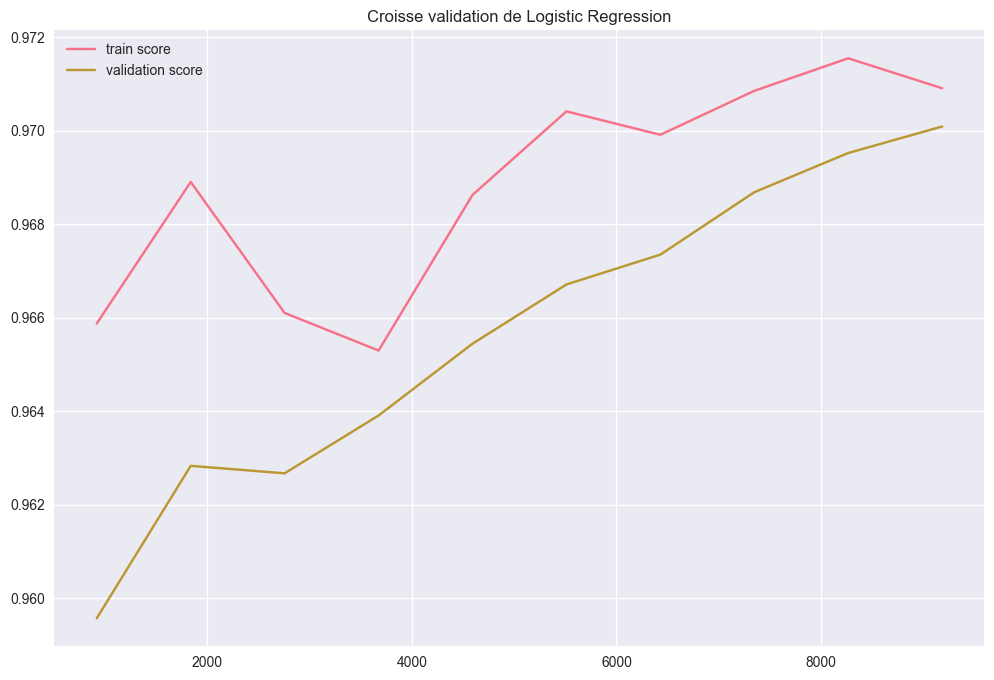

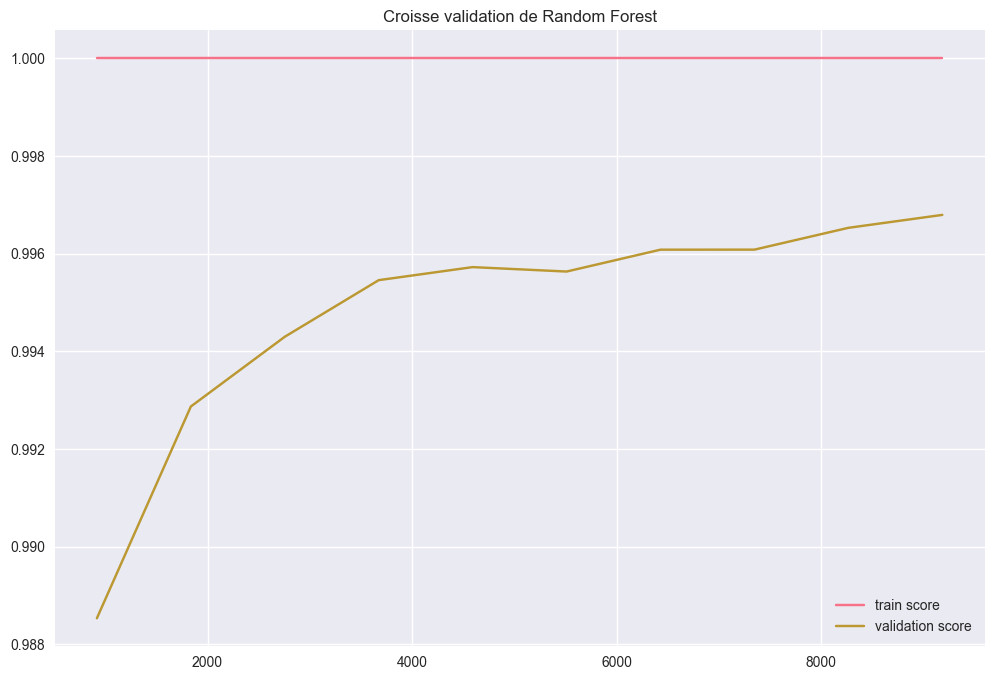

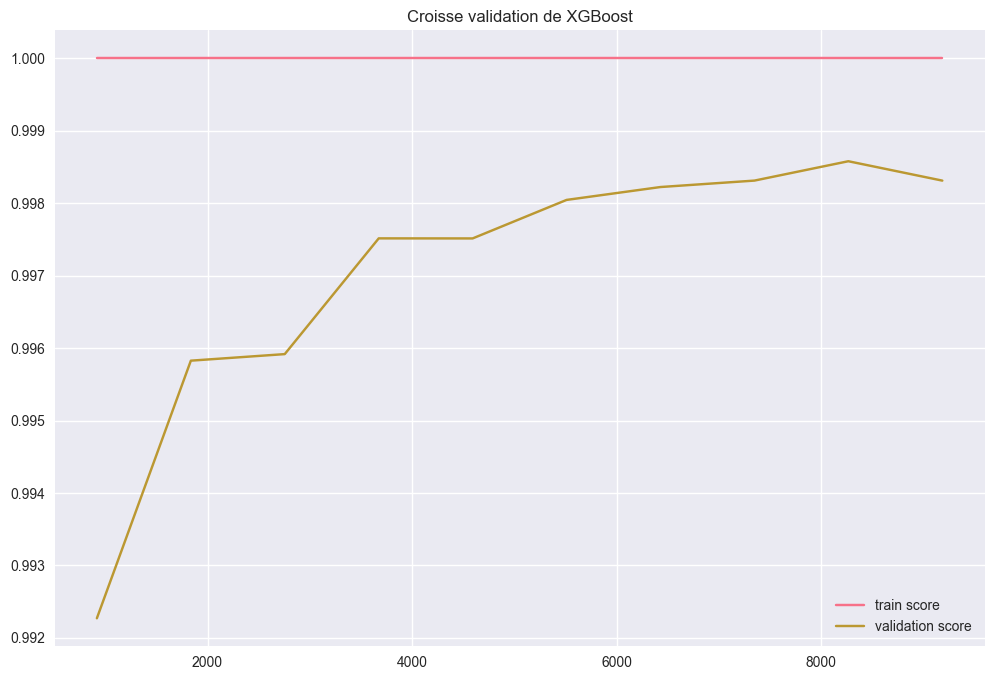

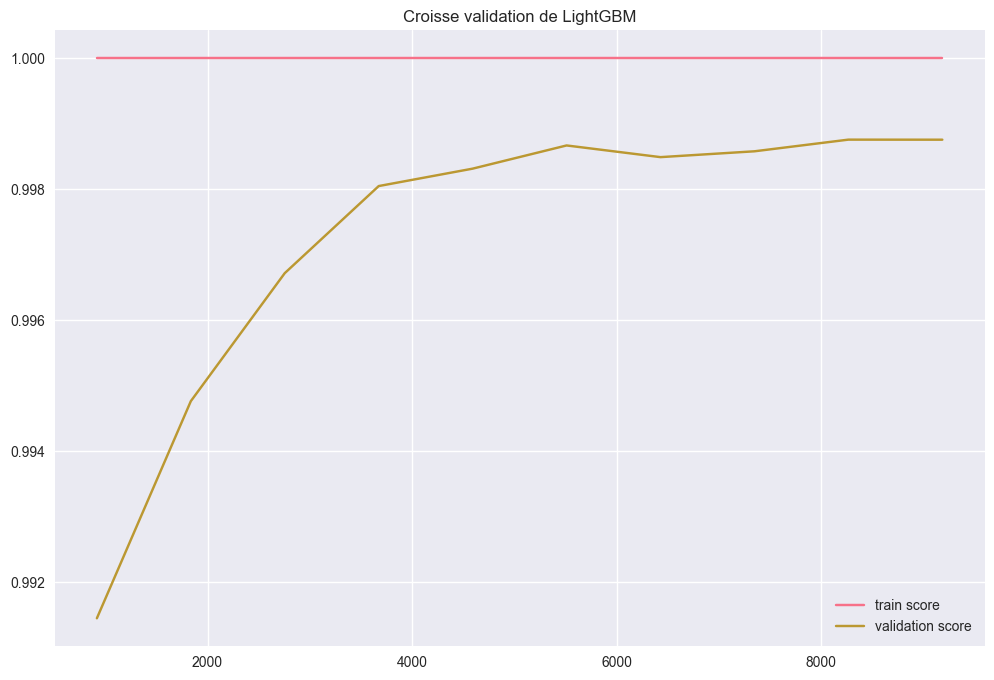

In [11]:
# Création d'un dictionnaire pour stocker les modèles
models = {
    'Logistic Regression':Logistic_Regression,
    #'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForest,
     'XGBoost': XGBoost,
     'LightGBM': LightGBM}

# def evaluation(model):
    
#     model.fit(X_train, y_train)
#     ypred = model.predict(X_test)
    
#     print(confusion_matrix(y_test, ypred))
#     print(classification_report(y_test, ypred))
    
#     N, train_score, val_score = learning_curve(model, X_train, y_train,
#                                               cv=4, scoring='f1',
#                                                train_sizes=np.linspace(0.1, 1, 10))
    
    
#     plt.figure(figsize=(12, 8))
#     plt.title(f"Croisse validation de {name}")
#     plt.plot(N, train_score.mean(axis=1), label='train score')
#     plt.plot(N, val_score.mean(axis=1), label='validation score')
#     plt.legend()

def evaluate_models_with_cv(models):
    results = {}
    for name, model in models.items():
        print(f"\nÉvaluation du modèle {name} avec cross-validation...")
        
        # # Cross-validation
        # cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
        # print(f"Scores de cross-validation (AUC-ROC): {cv_scores}")
        # print(f"Moyenne des scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        

        model.fit(X_train, y_train)
        
        # if hasattr(X_test, 'columns'): # S'assurer que X est un DataFrame avec des colonnes
        #     X_test.columns = X_test.columns.str.replace('[\[\]<]', '_', regex=True)
        ypred= model.predict(X_test)
       
        
        print(confusion_matrix(y_test, ypred))
        print(classification_report(y_test, ypred))
        
        N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                cv=4, scoring='f1',
                                                train_sizes=np.linspace(0.1, 1, 10))
        
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Croisse validation de {name}")
        plt.plot(N, train_score.mean(axis=1), label='train score')
        plt.plot(N, val_score.mean(axis=1), label='validation score')
        plt.legend()

        # Entraînement sur l'ensemble complet
        # Problème identifié : La `ValueError` "feature_names must be string, and may not contain [, ] or <"
        # indique que les noms de colonnes (features) de `X` (et donc de `X_train`/`X_test`) contiennent des caractères invalides
        # pour certains modèles comme XGBoost ou LightGBM.
        #
        # Solution appliquée ici pour l'entraînement sur l'ensemble complet (X, y) :
        # Nettoyage des noms de colonnes de `X` en remplaçant les caractères invalides ('[', ']', '<') par '_'.
        # Note : Idéalement, ce nettoyage devrait être effectué une seule fois sur le DataFrame `X` original,
        # avant la division en ensembles d'entraînement et de test (`X_train`, `X_test`).
        # Entraînement du modèle sur l'ensemble complet avec les noms de colonnes nettoyés
        
        # # Feature importance pour les modèles qui le supportent
        # if hasattr(model, 'feature_importances_'):
        #     feature_importance = pd.DataFrame({
        #         'feature': features,
        #         'importance': model.feature_importances_
        #     })
        #     feature_importance = feature_importance.sort_values('importance', ascending=False)
        #     print("\nTop 5 des features les plus importantes :")
        #     print(feature_importance.head(5))
        
        # results[name] = {
        #     'cv_scores': cv_scores,
        #     'cv_mean': cv_scores.mean(),
        #     'cv_std': cv_scores.std()
        # }
    
    return results

# Évaluation des modèles avec cross-validation
cv_results = evaluate_models_with_cv(models)
    

In [12]:
# Logistic_Regression.predict_proba(X_test)[2:5,1]

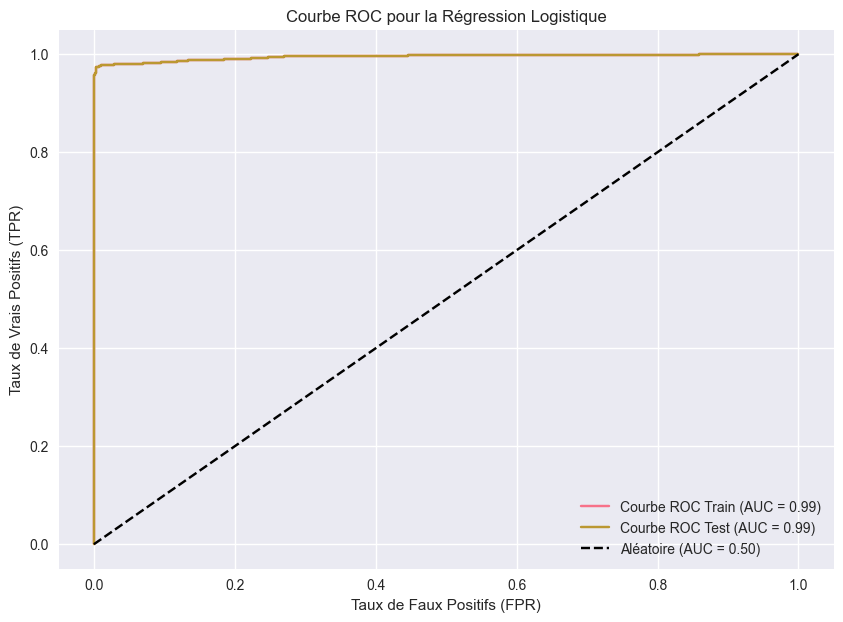

In [13]:
# for name, model in models.items():
#     print(name)
#     evaluation(model)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtenir les probabilités de la classe positive pour la courbe ROC
y_proba_lr_train = Logistic_Regression.predict_proba(X_train)[:, 1]
y_proba_lr_test = Logistic_Regression.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_proba_lr_train)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr_test)

# Calculer l'AUC (Area Under the Curve)
auc_lr_train = roc_auc_score(y_train, y_proba_lr_train)
auc_lr_test = roc_auc_score(y_test, y_proba_lr_test)

# Tracer la courbe ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'Courbe ROC Train (AUC = {auc_lr_train:.2f})')
plt.plot(fpr, tpr, label=f'Courbe ROC Test (AUC = {auc_lr_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.50)') # Ligne de référence aléatoire
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC pour la Régression Logistique')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Precision Recall Curve

In [14]:
precision, recall, threshold = precision_recall_curve(y_test, Logistic_Regression.decision_function(X_test))

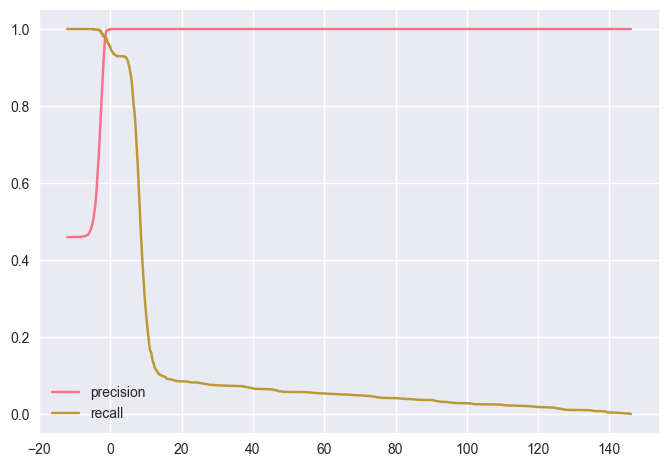

In [15]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [16]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold, model.predict_proba(X)[:,1]

In [17]:
y_pred = model_final(Logistic_Regression, X_test, threshold=0)
y_pred#[1][1:6]

(array([False,  True, False, ..., False, False,  True]),
 array([0.02506934, 0.99998618, 0.14634491, ..., 0.03647231, 0.02839643,
        0.99966765]))

In [18]:
print(f1_score(y_test, y_pred[0]), recall_score(y_test, y_pred[0]))

0.9745083758193737 0.9502840909090909


In [19]:
essaie = X_test.iloc[1:2]
essaie

,echa_impaye_avant,montant_credit,total_echeance,capital_rembourse,capital_restant,nbre_ech,taux_interet,age_credit_jours,nb_cpt,cum_taux_paiement,objet_credit_groupe_BUS,objet_credit_groupe_CAMION,objet_credit_groupe_ENGIN,objet_credit_groupe_MACHINE,objet_credit_groupe_REMORQUE,objet_credit_groupe_VOITURE,type_Société,segment_GE,segment_INS,segment_ME,segment_PAR,segment_PE,segment_TPE,profil_activite_Autres,profil_activite_Entreprise Privee Individuelle,profil_activite_Entreprise incubees,profil_activite_Organisme de l'Etat,profil_activite_Profession Liberale,secteur_risque_Activités Financières et Assurance,secteur_risque_Commerce,secteur_risque_Construction,secteur_risque_Energie,secteur_risque_Industries,secteur_risque_Production Autres Services,secteur_risque_Secteur Public,secteur_risque_Transports,secteur_risque_Télécommunications,forme_juridique_EURL,forme_juridique_GIE,forme_juridique_SA,forme_juridique_SARL,forme_juridique_SAS,forme_juridique_SCI,forme_juridique_SP,reseau_Douala Nord,reseau_Douala Sud,reseau_Est,reseau_Ouest,reseau_Yaounde Centre,reseau_Yaounde Nord,reseau_Yaounde Sud,reseau_Zone Nord,cat_age_entreprise_20+ ans,cat_age_entreprise_3-10 ans,cat_age_entreprise__3 ans,Retard_retard
id_echeance,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
563048_CBM01780_64,16,174591196,2708333.68,886611.91,1.051311e+08,96,14.5,488,1,0.0,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True


In [20]:
model_final(Logistic_Regression, essaie)

(array([ True]), array([0.99998618]))

## 5. Analyse des features importantes

Top 10 des features les plus importantes pour la Régression Logistique (par valeur absolue du coefficient) :
                                           feature  coefficient  \
0                                echa_impaye_avant    16.905510   
55                                   Retard_retard     4.819153   
37                            forme_juridique_EURL    -0.747690   
2                                   total_echeance     0.581412   
39                              forme_juridique_SA     0.496072   
24  profil_activite_Entreprise Privee Individuelle     0.447509   
16                                    type_Société    -0.445853   
15                     objet_credit_groupe_VOITURE     0.421112   
40                            forme_juridique_SARL     0.409708   
51                                reseau_Zone Nord    -0.407592   

    abs_coefficient  
0         16.905510  
55         4.819153  
37         0.747690  
2          0.581412  
39         0.496072  
24         0.447509  

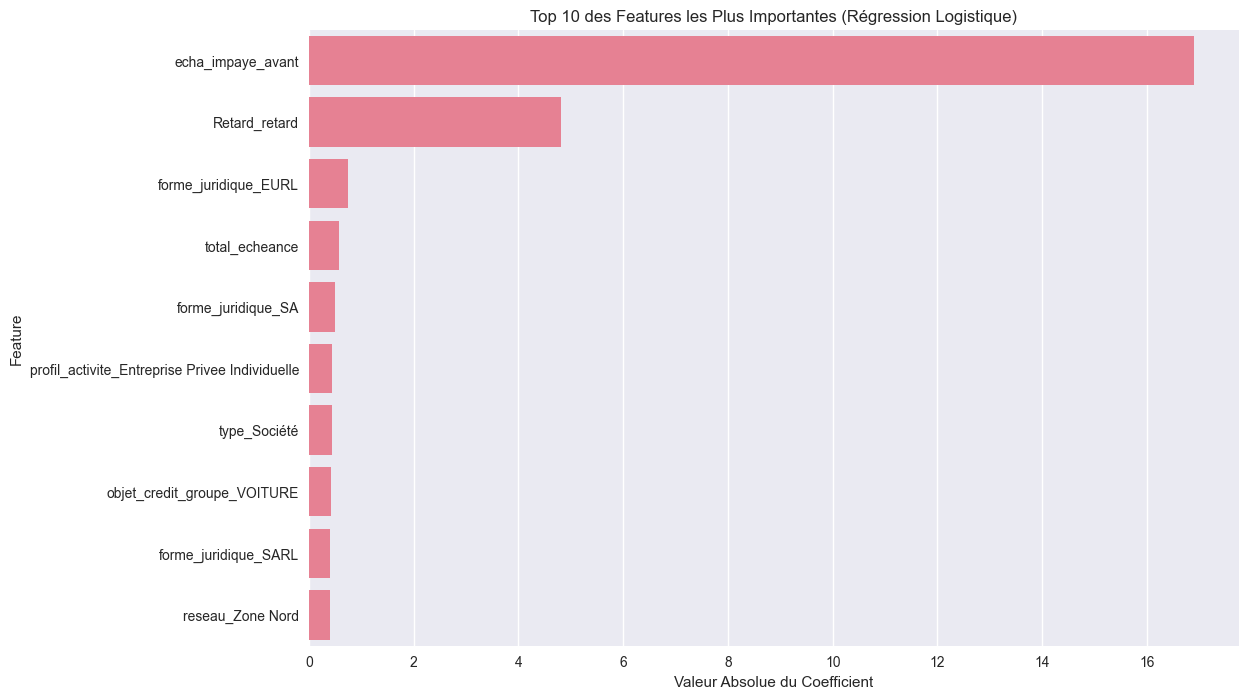

In [21]:
# Pour une régression logistique, l'importance des variables est donnée par les coefficients du modèle.
# Un coefficient plus élevé (en valeur absolue) indique une plus grande influence sur la prédiction.

# Récupérer le modèle de régression logistique entraîné
lr_model = models['Logistic Regression'].named_steps['logisticregression']

# Récupérer les noms des features (colonnes de X_train_scaled)
# Assurez-vous que X_train_scaled est un DataFrame pandas pour accéder aux noms de colonnes
features = X_train.columns

# Récupérer les coefficients du modèle
# Pour la classification binaire, lr_model.coef_ est un tableau 2D (1, n_features)
coefficients = lr_model.coef_[0]

# Créer un DataFrame pour visualiser les coefficients et les noms des features
feature_importance_lr = pd.DataFrame({
    'feature': features,
    'coefficient': coefficients
})

# Calculer la valeur absolue des coefficients pour classer par importance
feature_importance_lr['abs_coefficient'] = abs(feature_importance_lr['coefficient'])

# Trier les features par la valeur absolue de leurs coefficients en ordre décroissant
feature_importance_lr = feature_importance_lr.sort_values('abs_coefficient', ascending=False)

# Afficher les 10 features les plus importantes
print("Top 10 des features les plus importantes pour la Régression Logistique (par valeur absolue du coefficient) :")
print(feature_importance_lr.head(10))

# Visualiser les features les plus importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='abs_coefficient', y='feature', data=feature_importance_lr.head(10))
plt.title('Top 10 des Features les Plus Importantes (Régression Logistique)')
plt.xlabel('Valeur Absolue du Coefficient')
plt.ylabel('Feature')
plt.show()


## 6. Sauvegarde du modèle 

In [22]:
# Pour sauvegarder votre modèle de machine learning (ici, `Logistic_Regression`), vous pouvez utiliser la bibliothèque `joblib` ou `pickle`. `joblib` est souvent recommandée pour les modèles scikit-learn car elle est plus efficace pour les objets qui contiennent de grands tableaux NumPy.

# Option 1: Utiliser joblib (recommandé pour scikit-learn)
import joblib

# Définir le nom du fichier pour sauvegarder le modèle
filename_joblib = 'H:/ISE3_Nathan/GT/gt/Notre_code/Modelisation/logistic_regression_model.joblib'

# Sauvegarder le modèle
joblib.dump(Logistic_Regression, filename_joblib)
print(f"Modèle sauvegardé sous: {filename_joblib}")

# Pour charger le modèle plus tard:
# loaded_model_joblib = joblib.load(filename_joblib)
# print("Modèle chargé avec joblib.")
# # Vous pouvez maintenant utiliser loaded_model_joblib comme votre modèle original
# # Exemple: y_pred_loaded = model_final(loaded_model_joblib, X_test, threshold=0)


# Option 2: Utiliser pickle (plus générique, mais joblib est souvent préférable pour les modèles ML)
# import pickle

# # Définir le nom du fichier pour sauvegarder le modèle
# filename_pickle = 'logistic_regression_model.pkl'

# # Sauvegarder le modèle
# with open(filename_pickle, 'wb') as file:
#     pickle.dump(Logistic_Regression, file)
# print(f"Modèle sauvegardé sous: {filename_pickle}")

# Pour charger le modèle plus tard:
# with open(filename_pickle, 'rb') as file:
#     loaded_model_pickle = pickle.load(file)
# print("Modèle chargé avec pickle.")
# # Vous pouvez maintenant utiliser loaded_model_pickle
# # Exemple: y_pred_loaded = model_final(loaded_model_pickle, X_test, threshold=0)


Modèle sauvegardé sous: H:/ISE3_Nathan/GT/gt/Notre_code/Modelisation/logistic_regression_model.joblib


In [23]:
# Pour charger le modèle plus tard:
loaded_model_joblib = joblib.load("H:/ISE3_Nathan/GT/gt/Notre_code/Modelisation/logistic_regression_model.joblib")
print("Modèle chargé avec joblib.")
# Vous pouvez maintenant utiliser loaded_model_joblib comme votre modèle original
# Exemple: y_pred_loaded = model_final(loaded_model_joblib, X_test, threshold=0)

Modèle chargé avec joblib.


In [24]:
# Vous pouvez maintenant utiliser loaded_model_joblib comme votre modèle original
 
y_pred_loaded = model_final(loaded_model_joblib,X)
y_pred_loaded

(array([False, False, False, ..., False, False, False]),
 array([0.28538376, 0.26919724, 0.25386066, ..., 0.05555205, 0.06340692,
        0.07237873]))

In [25]:
# df = pd.DataFrame({"echa_impaye_avant": 2, 'montant_credit':1000000,
#             'total_echeance':100000, 'capital_rembourse':50000, 'capital_restant':950000, 'nbre_ech':10,
#             'taux_interet':7.5, 'age_credit_jours':20, 'nb_cpt':1, 'cum_taux_paiement':10,
#             'objet_credit_groupe':"VOITURE", 'type':'Société', 'segment':'GE', 'profil_activite':'Association', 
#             'secteur_risque':'Commerce', 'forme_juridique':'SA' , 'reseau':'Douala Centre', 
#             'cat_age_entreprise':'20+ ans', 'Retard':'pas_retard'},index=[2])
#         # Simulation de prédiction (à remplacer par votre modèle)
# def encode(df):
#     categorical_columns = ['objet_credit_groupe', 'type', 'segment', 'profil_activite', 
#                         'secteur_risque', 'forme_juridique', 'reseau', 'cat_age_entreprise', 'Retard']

#     # Dumméisation des variables catégorielles
#     df_dummy = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#     # Variables numériques à utiliser
#     numeric_features = ['echa_impaye_avant', 'montant_credit',
#                     'total_echeance', 'capital_rembourse', 'capital_restant', 'nbre_ech',
#                     'taux_interet', 'age_credit_jours', 'nb_cpt', 'cum_taux_paiement']

#     # Création des features en combinant variables numériques et dummifiées
#     features = numeric_features + [col for col in df_dummy.columns if col.startswith(tuple(categorical_columns))]

#     # Création de la variable cible binaire
#     #y = (base_leasing_dummy['statut'] == 'impaye').astype(int)
#     #y=df['statut'].map({"paye":0 , "impaye":1})

#     # Création de la matrice X
#     X = df_dummy[features]

#     return X

# X= encode(df)
# X

In [26]:
for col in categorical_columns:
    print(col, ":-----------------------", base_leasing[col].unique())

objet_credit_groupe :----------------------- ['VOITURE' 'AUTRE' 'CAMION' 'MACHINE' 'BUS' 'REMORQUE' 'ENGIN']
type :----------------------- ['Société' 'Entreprise Individuelle']
segment :----------------------- ['GE' 'ME' 'PE' 'INS' 'TPE' 'ASS' 'PAR']
profil_activite :----------------------- ['Autres' "Organisme de l'Etat" 'Entreprise Privee Individuelle'
 'Entreprise incubees' 'Association' 'Profession Liberale']
secteur_risque :----------------------- ['Commerce' 'Secteur Public' 'Activités Agro-Pastorales'
 'Activités Financières et Assurance' 'Industries' 'Construction'
 'Energie' 'Production Autres Services' 'Transports' 'Télécommunications']
forme_juridique :----------------------- ['SA' 'SARL' 'EURL' 'GIE' 'SAS' 'ASCO' 'SP' 'SCI']
reseau :----------------------- ['Yaounde Centre' 'Douala Centre' 'Ouest' 'Zone Nord' 'Douala Nord'
 'Douala Sud' 'Yaounde Sud' 'Est' 'Yaounde Nord']
cat_age_entreprise :----------------------- ['20+ ans' '10-20 ans' '3-10 ans' '<3 ans']
Retard :-------

In [27]:
# df2 = pd.DataFrame({"echa_impaye_avant": [1,2,3], 'montant_credit':[1000000,200000,250000],
#             'total_echeance':[100000,150000, 500000], 'capital_rembourse':[50000,100000,75000], 'capital_restant':[950000, 700000, 600000], 'nbre_ech':[10, 15, 20],
#             'taux_interet':[7.5, 6.5, 5], 'age_credit_jours':[20, 12, 15], 'nb_cpt':[1, 2, 1], 'cum_taux_paiement':[10,15, 5]
#             'objet_credit_groupe':["VOITURE",'CAMION','MACHINE'] , 'type':['Société','Entreprise Individuelle','Société'], 'segment':['GE','PE','INS'] , 
#             'profil_activite':['Association', 'Profession Liberale','Profession Liberale'], 
#             'secteur_risque':['Commerce','Secteur Public', 'Industries'], 'forme_juridique':['SA','SARL', 'EURL'] , 'reseau':['Douala Centre','Ouest','Zone Nord'] 
#             'cat_age_entreprise':['20+ ans','10-20 ans', '<3 ans' ], 'Retard':['pas_retard', 'retard', 'pas_retard']},index=[2, 4, 7])

# categorical_columns = ['objet_credit_groupe', 'type', 'segment', 'profil_activite', 
#                         'secteur_risque', 'forme_juridique', 'reseau', 'cat_age_entreprise', 'Retard']

# # Base d’entraînement
# train_df = pd.DataFrame({'Couleur': ['Rouge', 'Vert', 'Bleu']})
# train_dummies = pd.get_dummies(train_df)

# # Ligne test (seulement "Rouge")
# test_df = pd.DataFrame({'Couleur': ['Rouge']})
# test_dummies = pd.get_dummies(test_df)

# # Aligner les colonnes avec celles de l'entraînement
# test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)
# test_dummies

In [28]:
# # df2 = pd.DataFrame({"echa_impaye_avant": [1,2,3], 'montant_credit':[1000000,200000,250000],
# #             'total_echeance':[100000,150000, 500000], 'capital_rembourse':[50000,100000,75000], 'capital_restant':[950000, 700000, 600000], 'nbre_ech':[10, 15, 20],
# #             'taux_interet':[7.5, 6.5, 5], 'age_credit_jours':[20, 12, 15], 'nb_cpt':[1, 2, 1], 'cum_taux_paiement':[10,15, 5],
# #             'objet_credit_groupe':["VOITURE",'CAMION','MACHINE'] , 'type':['Société','Entreprise Individuelle','Société'], 'segment':['GE','PE','INS'] , 
# #             'profil_activite':['Association', 'Profession Liberale','Profession Liberale'], 
# #             'secteur_risque':['Commerce','Secteur Public', 'Industries'], 'forme_juridique':['SA','SARL', 'EURL'] , 'reseau':['Douala Centre','Ouest','Zone Nord'],            'cat_age_entreprise':['20+ ans','10-20 ans', '<3 ans' ], 'Retard':['pas_retard', 'retard', 'pas_retard']},index=[2, 4, 7])
# # df2_dummies= pd.get_dummies(df2)
# df2_test = pd.DataFrame({"echa_impaye_avant": 2, 'montant_credit':1000000,
#             'total_echeance':100000, 'capital_rembourse':50000, 'capital_restant':950000, 'nbre_ech':10,
#             'taux_interet':7.5, 'age_credit_jours':20, 'nb_cpt':1, 'cum_taux_paiement':10,
#             'objet_credit_groupe':"VOITURE", 'type':'Société', 'segment':'GE', 'profil_activite':'Association', 
#             'secteur_risque':'Commerce', 'forme_juridique':'SA' , 'reseau':'Douala Centre', 
#             'cat_age_entreprise':'20+ ans', 'Retard':'pas_retard'},index=[2])
# # df2_test_dummies= pd.get_dummies(df2_test)
# # # Aligner les colonnes avec celles de l'entraînement
# # df2_test_dummies = df2_test_dummies.reindex(columns=df2_dummies.columns, fill_value=False)
# # df2_test_dummies

In [29]:
# def encode(df):
#     categorical_columns = ['objet_credit_groupe', 'type', 'segment', 'profil_activite', 
#                         'secteur_risque', 'forme_juridique', 'reseau', 'cat_age_entreprise', 'Retard']

#     # Dumméisation des variables catégorielles
#     df_dummy = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#     # Variables numériques à utiliser
#     numeric_features = ['echa_impaye_avant', 'montant_credit',
#                     'total_echeance', 'capital_rembourse', 'capital_restant', 'nbre_ech',
#                     'taux_interet', 'age_credit_jours', 'nb_cpt', 'cum_taux_paiement']

#     # Création des features en combinant variables numériques et dummifiées
#     features = numeric_features + [col for col in df_dummy.columns if col.startswith(tuple(categorical_columns))]
    
#     # essaie_train = df.iloc[1:3]
#     # essaie_train_dummies= pd.get_dummies(essaie_train)
#     # Création de la variable cible binaire
#     #y = (base_leasing_dummy['statut'] == 'impaye').astype(int)
#     #y=df['statut'].map({"paye":0 , "impaye":1})
#     essaie_train = pd.DataFrame({"echa_impaye_avant": [1,2,3], 'montant_credit':[1000000,200000,250000],
#                  'total_echeance':[100000,150000, 500000], 'capital_rembourse':[50000,100000,75000], 'capital_restant':[950000, 700000, 600000], 'nbre_ech':[10, 15, 20],
#                  'taux_interet':[7.5, 6.5, 5], 'age_credit_jours':[20, 12, 15], 'nb_cpt':[1, 2, 1], 'cum_taux_paiement':[10,15, 5],
#                  'objet_credit_groupe':["VOITURE",'CAMION','MACHINE'] , 'type':['Société','Entreprise Individuelle','Société'], 'segment':['GE','PE','INS'] , 
#                  'profil_activite':['Association', 'Profession Liberale','Profession Liberale'], 
#                  'secteur_risque':['Commerce','Secteur Public', 'Industries'], 'forme_juridique':['SA','SARL', 'EURL'] , 'reseau':['Douala Centre','Ouest','Zone Nord'],            'cat_age_entreprise':['20+ ans','10-20 ans', '<3 ans' ], 'Retard':['pas_retard', 'retard', 'pas_retard']},index=[2, 4, 7])
    
#     essaie_train_dummies= pd.get_dummies(essaie_train, drop_first=True)
#     # df2_test = pd.DataFrame({"echa_impaye_avant": 2, 'montant_credit':1000000,
#     #             'total_echeance':100000, 'capital_rembourse':50000, 'capital_restant':950000, 'nbre_ech':10,
#     #             'taux_interet':7.5, 'age_credit_jours':20, 'nb_cpt':1, 'cum_taux_paiement':10,
#     #             'objet_credit_groupe':"VOITURE", 'type':'Société', 'segment':'GE', 'profil_activite':'Association', 
#     #             'secteur_risque':'Commerce', 'forme_juridique':'SA' , 'reseau':'Douala Centre', 
#     #             'cat_age_entreprise':'20+ ans', 'Retard':'pas_retard'},index=[2])
#     #df2_test_dummies= pd.get_dummies(df2_test)
#     df_test_dummies=pd.get_dummies(df, drop_first=True)
#     # Aligner les colonnes avec celles de l'entraînement
#     df_test_dummies = df_test_dummies.reindex(columns=essaie_train_dummies.columns, fill_value=False)
    

#         # Création de la matrice X
#     X = df_test_dummies

#     return X

# X= encode(df2_test)
# X

In [30]:
#y_pred_loaded =
#model_final(loaded_model_joblib, X,threshold=0)


In [31]:
# Problème identifié : ValueError - Les noms des caractéristiques (features) ne correspondent pas.
# Cela signifie que les colonnes du DataFrame 'X' passé au modèle ne sont pas les mêmes
# que celles sur lesquelles le modèle 'Logistic_Regression' a été entraîné.
#
# Causes possibles de ce problème :
# 1.  **Inconsistance de l'encodage One-Hot (pd.get_dummies)** : Lorsque `pd.get_dummies` est appliqué
#     sur de nouvelles données (ici `df2_test` via la fonction `encode`), il peut générer un ensemble
#     de colonnes différent de celui des données d'entraînement. Cela se produit si les nouvelles
#     données contiennent des catégories qui n'étaient pas présentes à l'entraînement, ou si
#     certaines catégories présentes à l'entraînement sont absentes des nouvelles données.
#     L'erreur mentionne spécifiquement des colonnes "unseen at fit time" (ex: `cat_age_entreprise_<3 ans`)
#     et des colonnes "seen at fit time, yet now missing" (ex: `cat_age_entreprise_3-10 ans`,
#     `cat_age_entreprise__3 ans`, `forme_juridique_EURL`, etc.).
# 2.  **Référence de colonnes incorrecte** : La fonction `encode` utilise `essaie_train_dummies.columns`
#     pour réaligner les colonnes de `df_test_dummies`. Cependant, `essaie_train` est un petit
#     DataFrame d'exemple. Il est très probable que les colonnes générées par `pd.get_dummies`
#     à partir de `essaie_train` ne représentent pas l'ensemble complet et exact des colonnes
#     utilisées pour entraîner le modèle `Logistic_Regression`.
#
# Correction :
# Pour résoudre ce `ValueError`, il est impératif que le DataFrame `X` (qui est le résultat de `encode(df2_test)`)
# ait **exactement les mêmes colonnes, dans le même ordre**, que les données sur lesquelles le modèle
# `Logistic_Regression` a été entraîné.
#
# Les étapes pour corriger cela sont les suivantes :
# 1.  **Récupérer les noms des caractéristiques d'entraînement** : Le modèle `Logistic_Regression`
#     (s'il est un modèle scikit-learn entraîné) devrait stocker les noms des colonnes d'entraînement
#     dans son attribut `feature_names_in_`.
#     Exemple : `colonnes_entrainement = Logistic_Regression.feature_names_in_`
#
# 2.  **Modifier la fonction `encode`** : La fonction `encode` doit être mise à jour pour prendre
#     en paramètre cette liste `colonnes_entrainement` et l'utiliser pour le réalignement final
#     des colonnes du DataFrame de test.
#
# Voici comment la fonction `encode` devrait être modifiée conceptuellement (la modification
# directe de la fonction `encode` n'est pas possible dans cette sélection, mais c'est la source du problème) :
#
# ```python
# def encode(df, training_columns_reference):
#     # ... (votre logique existante pour les features numériques et catégorielles)
#     # ...
#     df_test_dummies = pd.get_dummies(df, drop_first=True)
#
#     # Aligner les colonnes avec celles de l'entraînement en utilisant la référence correcte
#     df_test_dummies = df_test_dummies.reindex(columns=training_columns_reference, fill_value=False)

#
#     X = df_test_dummies
#     return X
# ```
#
# Ensuite, l'appel à la fonction `encode` devrait ressembler à ceci (avant cette ligne de code) :
#
# ```python
# # Assurez-vous que Logistic_Regression est bien le modèle entraîné et chargé
# if hasattr(Logistic_Regression, 'feature_names_in_'):
#     colonnes_entrainement = Logistic_Regression.feature_names_in_
# else:
#     # Gérer le cas où l'attribut n'existe pas, peut-être charger une liste de colonnes sauvegardée
#     print("L'attribut feature_names_in_ n'est pas disponible sur le modèle. Assurez-vous que le modèle est correctement entraîné et chargé.")
#     # Pour l'instant, nous allons supposer qu'il existe ou qu'une liste de colonnes est disponible
#     # Vous devrez peut-être charger cette liste depuis un fichier si elle n'est pas dans le modèle
#     # colonnes_entrainement = charger_mes_colonnes_entrainement()
#
# # Appeler la fonction encode avec la référence des colonnes d'entraînement
# X = encode(df2_test, colonnes_entrainement)
# ```
#
# Sans cette correction dans la préparation de `X`, l'appel `model_final(Logistic_Regression, X)`
# continuera à échouer avec le `ValueError` car `X` ne correspondra pas aux attentes du modèle.
#model_final(Logistic_Regression, X)

In [32]:

# len(pd.DataFrame(X_train.values[1:3], columns=X_train.columns).columns)

In [33]:
# df = pd.DataFrame({"echa_impaye_avant": 2, 'montant_credit':1000000,
#             'total_echeance':100000, 'capital_rembourse':50000, 'capital_restant':950000, 'nbre_ech':10,
#             'taux_interet':7.5, 'age_credit_jours':20, 'nb_cpt':1, 'cum_taux_paiement':10,
#             'objet_credit_groupe':"VOITURE", 'type':'Société', 'segment':'GE', 'profil_activite':'Association', 
#             'secteur_risque':'Commerce', 'forme_juridique':'SA' , 'reseau':'Douala Centre', 
#             'cat_age_entreprise':'20+ ans', 'Retard':'pas_retard'},index=[2])
#         # Simulation de prédiction (à remplacer par votre modèle)
# def encode(df):
#     categorical_columns = ['objet_credit_groupe', 'type', 'segment', 'profil_activite', 
#                         'secteur_risque', 'forme_juridique', 'reseau', 'cat_age_entreprise', 'Retard']

#     # Dumméisation des variables catégorielles
#     df_dummy = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#     # Variables numériques à utiliser
#     numeric_features = ['echa_impaye_avant', 'montant_credit',
#                     'total_echeance', 'capital_rembourse', 'capital_restant', 'nbre_ech',
#                     'taux_interet', 'age_credit_jours', 'nb_cpt', 'cum_taux_paiement']

#     # Création des features en combinant variables numériques et dummifiées
#     features = numeric_features + [col for col in df_dummy.columns if col.startswith(tuple(categorical_columns))]

#     # Création de la variable cible binaire
#     #y = (base_leasing_dummy['statut'] == 'impaye').astype(int)
#     #y=df['statut'].map({"paye":0 , "impaye":1})

#     # Création de la matrice X
#     X = df_dummy[features]

#     return X

# X= encode(df)
# X

In [34]:

# training_columns_reference = Logistic_Regression.feature_names_in_

# def encode(df, training_columns_reference):
#     # ... (votre logique existante pour les features numériques et catégorielles)
#     # ...
#     df_test_dummies = pd.get_dummies(df, drop_first=True)

#     # Aligner les colonnes avec celles de l'entraînement en utilisant la référence correcte
#     df_test_dummies = df_test_dummies.reindex(columns=training_columns_reference, fill_value=False)


#     X = df_test_dummies
#     return X
# # ```

# # Ensuite, l'appel à la fonction `encode` devrait ressembler à ceci (avant cette ligne de code) :

# # Assurez-vous que Logistic_Regression est bien le modèle entraîné et chargé
# if hasattr(Logistic_Regression, 'feature_names_in_'):
#     colonnes_entrainement = Logistic_Regression.feature_names_in_
# else:
#     # Gérer le cas où l'attribut n'existe pas, peut-être charger une liste de colonnes sauvegardée
#     print("L'attribut feature_names_in_ n'est pas disponible sur le modèle. Assurez-vous que le modèle est correctement entraîné et chargé.")
#     # Pour l'instant, nous allons supposer qu'il existe ou qu'une liste de colonnes est disponible
#     # Vous devrez peut-être charger cette liste depuis un fichier si elle n'est pas dans le modèle
#     # colonnes_entrainement = charger_mes_colonnes_entrainement()

# # Appeler la fonction encode avec la référence des colonnes d'entraînement
# X = encode(df2_test, colonnes_entrainement)


# # Sans cette correction dans la préparation de `X`, l'appel `model_final(Logistic_Regression, X)`
# #     continuera à échouer avec le `ValueError` car `X` ne correspondra pas aux attentes du modèle.

# # new_func()

In [35]:
def encode2(df):
    categorical_columns = ['objet_credit_groupe', 'type', 'segment', 'profil_activite', 
                        'secteur_risque', 'forme_juridique', 'reseau', 'cat_age_entreprise', 'Retard']

    # Dumméisation des variables catégorielles
    df_dummy = pd.get_dummies(df, columns=categorical_columns, drop_first=True)



    # Variables numériques à utiliser

    numeric_features = ['echa_impaye_avant', 'montant_credit',
                    'total_echeance', 'capital_rembourse', 'capital_restant', 'nbre_ech',
                    'taux_interet', 'age_credit_jours', 'nb_cpt', 'cum_taux_paiement']

    # Création des features en combinant variables numériques et dummifiées
    features = numeric_features + [col for col in df_dummy.columns if col.startswith(tuple(categorical_columns))]

    # Création de la variable cible binaire
    #y = (base_leasing_dummy['statut'] == 'impaye').astype(int)
    #y =df['statut'].map({"paye":0 , "impaye":1})

    # Création de la matrice X
    X = df_dummy[features]
    if hasattr(X, 'columns'): # S'assurer que X est un DataFrame avec des colonnes
        X.columns = X.columns.str.replace('[\[\]<]', '_', regex=True)

    return X

X = encode2(base_leasing)
len(X.columns)

56

In [36]:
df_prediction = pd.DataFrame({"echa_impaye_avant": 2, 'montant_credit':1000000,
            'total_echeance':100000, 'capital_rembourse':50000, 'capital_restant':950000, 'nbre_ech':10,
            'taux_interet':7.5, 'age_credit_jours':20, 'nb_cpt':1, 'cum_taux_paiement':10,
            'objet_credit_groupe':"VOITURE", 'type':'Société', 'segment':'GE', 'profil_activite':'Association', 
            'secteur_risque':'Commerce', 'forme_juridique':'SA' , 'reseau':'Douala Centre', 
            'cat_age_entreprise':'20+ ans', 'Retard':'pas_retard'},index=[2])

# # df_prediction = pd.DataFrame({"echa_impaye_avant":ech_impaye_avant, 'montant_credit':montant_credit,
# #             'total_echeance':total_echeance, 'capital_rembourse':capital_rembourse, 'capital_restant':capital_restant, 'nbre_ech':nbre_ech,
# #             'taux_interet':taux_interet, 'age_credit_jours':age_credit_jours, 'nb_cpt':nb_cpt, 'cum_taux_paiement':cum_taux_paiement,
# #             'objet_credit_groupe':objet_credit, 'type':type_entreprise, 'segment':segment, 'profil_activite':profil_activite, 
# #             'secteur_risque':secteur_risque, 'forme_juridique':forme_juridique, 'reseau':reseau, 
# #             'cat_age_entreprise':cat_age_entreprise, 'Retard':statut_retard},index=[n_ech])

# def dataframe_prediction(df,df_prediction):
#     X= encode2(df)
#     df_prediction_dummies = pd.get_dummies(df_prediction, drop_first=True)
#     df_prediction_dummies = df_prediction_dummies.reindex(columns=X.columns, fill_value=False)

#     X_ = df_prediction_dummies
#     return X

# X= dataframe_prediction(base_leasing, df_prediction)
# X    
# #model_final(Logistic_Regression, X)

In [37]:
X = encode2(base_leasing)
# len(X.columns)
df_prediction_dummies= encode2(df_prediction)
df_prediction_dummies = df_prediction_dummies.reindex(columns=X.columns, fill_value=False)


In [38]:
model_final(Logistic_Regression, df_prediction_dummies)

# L'origine du problème est un décalage dans les noms de colonnes générés par l'encodage one-hot (via `pd.get_dummies` ou la fonction `encode2`) pour la variable 'cat_age_entreprise'.
# Le modèle `Logistic_Regression` a été entraîné avec une colonne nommée 'cat_age_entreprise__3 ans' (comme le montre `Logistic_Regression.feature_names_in_`).
# Cependant, lors de la préparation des données de prédiction (`df_prediction_dummies`), la même catégorie a généré une colonne nommée 'cat_age_entreprise_<3 ans'.
# Le message d'erreur "Feature names unseen at fit time: - cat_age_entreprise_<3 ans" indique que cette colonne est nouvelle pour le modèle.
# Et "Feature names seen at fit time, yet now missing: - cat_age_entreprise__3 ans" indique que la colonne attendue par le modèle est absente des données de prédiction.
# Bien que `reindex` soit utilisé pour aligner les colonnes, il ne corrige pas les noms de colonnes existants qui sont différents. Il ajoute simplement les colonnes manquantes (comme 'cat_age_entreprise__3 ans' avec des valeurs False) et laisse les colonnes inattendues (comme 'cat_age_entreprise_<3 ans') qui ne correspondent pas aux noms attendus par le modèle.
# Pour résoudre ce problème, il faut s'assurer que les noms de colonnes générés par l'encodage sont identiques entre les données d'entraînement et les données de prédiction. Cela peut être fait en standardisant les valeurs de la colonne 'cat_age_entreprise' avant l'encodage, ou en utilisant un `OneHotEncoder` de scikit-learn qui est ajusté sur les données d'entraînement et ensuite utilisé pour transformer les deux ensembles de données.


(array([False]), array([0.0885795]))

In [39]:
Logistic_Regression.feature_names_in_[30:56]

array(['secteur_risque_Construction', 'secteur_risque_Energie',
       'secteur_risque_Industries',
       'secteur_risque_Production Autres Services',
       'secteur_risque_Secteur Public', 'secteur_risque_Transports',
       'secteur_risque_Télécommunications', 'forme_juridique_EURL',
       'forme_juridique_GIE', 'forme_juridique_SA',
       'forme_juridique_SARL', 'forme_juridique_SAS',
       'forme_juridique_SCI', 'forme_juridique_SP', 'reseau_Douala Nord',
       'reseau_Douala Sud', 'reseau_Est', 'reseau_Ouest',
       'reseau_Yaounde Centre', 'reseau_Yaounde Nord',
       'reseau_Yaounde Sud', 'reseau_Zone Nord',
       'cat_age_entreprise_20+ ans', 'cat_age_entreprise_3-10 ans',
       'cat_age_entreprise__3 ans', 'Retard_retard'], dtype=object)

In [40]:
df_prediction_dummies.columns[30:56]

Index(['secteur_risque_Construction', 'secteur_risque_Energie',
       'secteur_risque_Industries',
       'secteur_risque_Production Autres Services',
       'secteur_risque_Secteur Public', 'secteur_risque_Transports',
       'secteur_risque_Télécommunications', 'forme_juridique_EURL',
       'forme_juridique_GIE', 'forme_juridique_SA', 'forme_juridique_SARL',
       'forme_juridique_SAS', 'forme_juridique_SCI', 'forme_juridique_SP',
       'reseau_Douala Nord', 'reseau_Douala Sud', 'reseau_Est', 'reseau_Ouest',
       'reseau_Yaounde Centre', 'reseau_Yaounde Nord', 'reseau_Yaounde Sud',
       'reseau_Zone Nord', 'cat_age_entreprise_20+ ans',
       'cat_age_entreprise_3-10 ans', 'cat_age_entreprise__3 ans',
       'Retard_retard'],
      dtype='object')

In [41]:
#print(len(Logistic_Regression.feature_names_in_),len(df_prediction_dummies.columns))